# MNIST Handwritten Digit Recognition in PyTorch

Handwritten digit recognition is the classical 'Hello World" exercice of machine learning. 

Here we'll see that it can be done rather efficiently already with a simple feedforward neural network.

Example taken from:

* Main source: https://towardsdatascience.com/a-simple-starter-guide-to-build-a-neural-network-3c2cf07b8d7c

* Complemented with: https://nextjournal.com/gkoehler/pytorch-mnist

![image.png](attachment:image.png)

## Import PyTorch

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt # For plots

## Initialize Hyper-parameters

In [2]:
input_size = 784       # The image size = 28 x 28 = 784
hidden_size = 500      # The number of nodes at the hidden layer
num_classes = 10       # The number of output classes. In this case, from 0 to 9
num_epochs = 5         # The number of times entire dataset is trained
batch_size = 100       # The size of input data took for one iteration
learning_rate = 0.001  # The speed of convergence

## Download MNIST Dataset

The MNIST database (Yann LeCun et al) consists of images 28 * 28 pixel greyscale images of handwritten digits.

It has a training set of 60,000 examples, and a test set of 10,000 examples.

The dataset will be downladed (once) just below.

In [3]:
train_dataset = dsets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = dsets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

## Load the Dataset

We shuffle the loading process of train_dataset to make the learning process independent of data orderness, but the order of test_loader remains to examine whether we can handle unspecified bias order of inputs.

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

## Let's take a look at some examples. 
We'll use the test_loader for this.

batch data: torch.Size([100, 1, 28, 28])


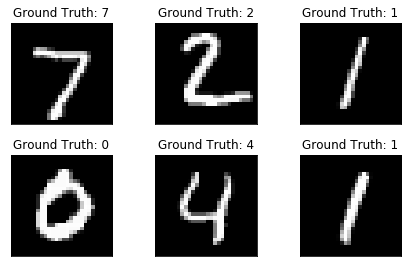

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# Let's see what one test data batch consists of
# --> we have [batch_size] examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one). 
print("batch data:", example_data.shape)

# Plot some examples with matplotlib
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
    
plt.show()

## Feedforward Neural Network Model using nn.Sequential

Use the nn package to define our model as a sequence of layers. nn.Sequential is a Module which contains other Modules, and applies them in sequence to produce its output. Each Linear Module computes output from input using a linear function, and holds internal Tensors for its weight and bias.

In [6]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)

In [11]:
class ConvNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(0.05),
            nn.MaxPool2d(3),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(0.05),
            nn.MaxPool2d(2),
        )
        self.convs = nn.ModuleList([nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.5),
            nn.LeakyReLU(0.05)) for _ in range(10)])
    
        self.fc = nn.Sequential(
            Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout2d(0.5),
            nn.LeakyReLU(0.03),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.Dropout2d(0.5),
            nn.LeakyReLU(0.03),
            nn.Linear(256, 10),
        )
        
    def forward(self, x):
        x = self.features(x)
        for conv in self.convs:
            x = x + conv(x)
        return self.fc(x)

## Enable GPU 

In [17]:
net = ConvNN().cuda()    # You can comment out this line to disable GPU

## Choose the Loss Function and Optimizer

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

## Counters

In [19]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs + 1)]

## Train the FNN Model

Note: torch.nn only supports mini-batches. The entire torch.nn package only supports inputs that are a mini-batch of samples, and not a single sample. If you have a single sample, just use input.unsqueeze(0) to add a fake batch dimension.

In [20]:
num_epochs

5

In [ ]:
net.train()

for epoch in range(100):
    for i, (images, labels) in enumerate(train_loader):   # Load a batch of images with its (index, data, class)        
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
        outputs = net(images)                             # Forward pass: compute the output class given a image
        loss = criterion(outputs, labels)                 # Compute the loss: difference between the output class and the pre-given label
        loss.backward()                                   # Backward pass: compute the weight
        optimizer.step()                                  # Optimizer: update the weights of hidden nodes
        
        if (i+1) % 100 == 0:                              # Logging
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item()))
            
        if (i+1) % 10 == 0:                              # keep track of loss value
            train_losses.append(loss.item())
            train_counter.append(((i+1)*batch_size) + ((epoch)*len(train_loader.dataset)))

Epoch [1/5], Step [100/600], Loss: 0.8814
Epoch [1/5], Step [200/600], Loss: 0.4144
Epoch [1/5], Step [300/600], Loss: 0.2860
Epoch [1/5], Step [400/600], Loss: 0.2486
Epoch [1/5], Step [500/600], Loss: 0.2140
Epoch [1/5], Step [600/600], Loss: 0.2391
Epoch [2/5], Step [100/600], Loss: 0.1077
Epoch [2/5], Step [200/600], Loss: 0.3042
Epoch [2/5], Step [300/600], Loss: 0.3398
Epoch [2/5], Step [400/600], Loss: 0.1505
Epoch [2/5], Step [500/600], Loss: 0.2274
Epoch [2/5], Step [600/600], Loss: 0.1106
Epoch [3/5], Step [100/600], Loss: 0.2211
Epoch [3/5], Step [200/600], Loss: 0.1397
Epoch [3/5], Step [300/600], Loss: 0.0958
Epoch [3/5], Step [400/600], Loss: 0.1908
Epoch [3/5], Step [500/600], Loss: 0.0485
Epoch [3/5], Step [600/600], Loss: 0.0964
Epoch [4/5], Step [100/600], Loss: 0.1878
Epoch [4/5], Step [200/600], Loss: 0.1508
Epoch [4/5], Step [300/600], Loss: 0.1573
Epoch [4/5], Step [400/600], Loss: 0.0837
Epoch [4/5], Step [500/600], Loss: 0.0816
Epoch [4/5], Step [600/600], Loss:

## Test the FNN Model

Similar to training the neural network, we also need to load batches of test images and collect the outputs. The differences are that:
* No loss & weights calculation
* No weights update
* Has correct prediction calculation

In [14]:
net.eval()

correct = 0
total = 0
for images, labels in test_loader:
    images = images.cuda()
    outputs = net(images).cpu()
    _, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
    total += labels.size(0)                    # Increment the total count
    correct += (predicted == labels).sum()     # Increment the correct count
    
print('Accuracy of the network on the 10K test images: {}'.format(100 * (correct.item() / total)))

Accuracy of the network on the 10K test images: 99.48


## Evaluating the Model's Performance

Show in a plot (using mathplotlib) the evolution of the loss as a function of the number of training example seen. 

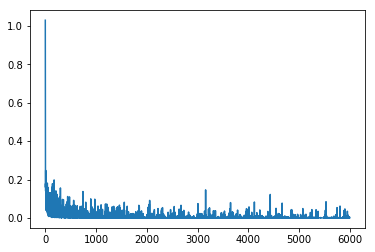

In [71]:
plt.plot(train_losses)
plt.show()